<a href="https://colab.research.google.com/github/mikeroguez/experimento/blob/main/Examenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Normalización**

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Definir rutas de entrada y salida
input_file = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes.csv"
output_file = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_normalizado.csv"

# Cargar el dataset
dataset = pd.read_csv(input_file)

# Paso 1: Normalizar total_score en base 10 utilizando max_score y redondear a 2 decimales
dataset['normalized_score'] = ((dataset['total_score'] / dataset['max_score']) * 10).round(2)

# Imputar valores faltantes en normalized_score basado en total_score
dataset.loc[dataset['total_score'] == 0, 'normalized_score'] = 0

# Paso 2: Limpiar y convertir start_date y finish_date a tipo datetime
dataset['start_date'] = dataset['start_date'].astype(str).str.replace('"', '', regex=False)  # Eliminar comillas dobles
dataset['start_date'] = pd.to_datetime(dataset['start_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

dataset['finish_date'] = pd.to_datetime(dataset['finish_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Paso 3: Manejar valores nulos en try_value y first_score_value
dataset['try_value'] = dataset['try_value'].fillna(0)
dataset['first_score_value'] = dataset['first_score_value'].fillna(0)

# Paso 4: Calcular elapsed_time en minutos (redondeado a entero)
dataset['elapsed_time'] = (
    (dataset['finish_date'] - dataset['start_date'])
    .dt.total_seconds()
    .div(60)
    .fillna(0)
    .astype(int)
)

# Corregir valores negativos en elapsed_time
dataset['elapsed_time'] = dataset['elapsed_time'].clip(lower=0)

# Paso 5: Calcular z-score para cada applicationKey
dataset['std_score'] = dataset.groupby('applicationKey')['normalized_score'].transform(zscore)

# Paso 6: Eliminar la columna is_scored antes de guardar
dataset = dataset.drop(columns=['is_scored'], errors='ignore')

# Guardar el dataset normalizado
dataset.to_csv(output_file, index=False)

print("✅ Archivo normalizado y descargado exitosamente, con z-score agregado, fechas corregidas y sin la columna 'is_scored'.")

✅ Archivo normalizado y descargado exitosamente, con z-score agregado, fechas corregidas y sin la columna 'is_scored'.


**2. Limpiar**

In [ ]:
import pandas as pd

# Definir rutas de entrada y salida
input_tareas = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/tareas/tareas_consolidado_cleaned_sin_cursos_reutilizados.csv"
input_examenes = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_normalizado.csv"
output_examenes = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_limpio.csv"

# Cargar el dataset de tareas y obtener los groupKey únicos
tareas_df = pd.read_csv(input_tareas)
group_keys_validos = set(tareas_df['groupKey'].unique())

# Cargar el dataset de exámenes
examenes_df = pd.read_csv(input_examenes)

# Filtrar los registros donde el groupKey esté en la lista de válidos
examenes_filtrados = examenes_df[examenes_df['groupKey'].isin(group_keys_validos)]

# Guardar el dataset filtrado
examenes_filtrados.to_csv(output_examenes, index=False)

print("✅ Dataset de exámenes limpio y guardado exitosamente.")

✅ Dataset de exámenes limpio y guardado exitosamente.


**3. Tiempo anomalo**

<ipython-input-8-9fa5484f939f>:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("applicationKey", group_keys=False).apply(detect_outliers)


✅ Detección de outliers completada. Archivo guardado en:
/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_con_tiempos_fuera_de_rango.csv


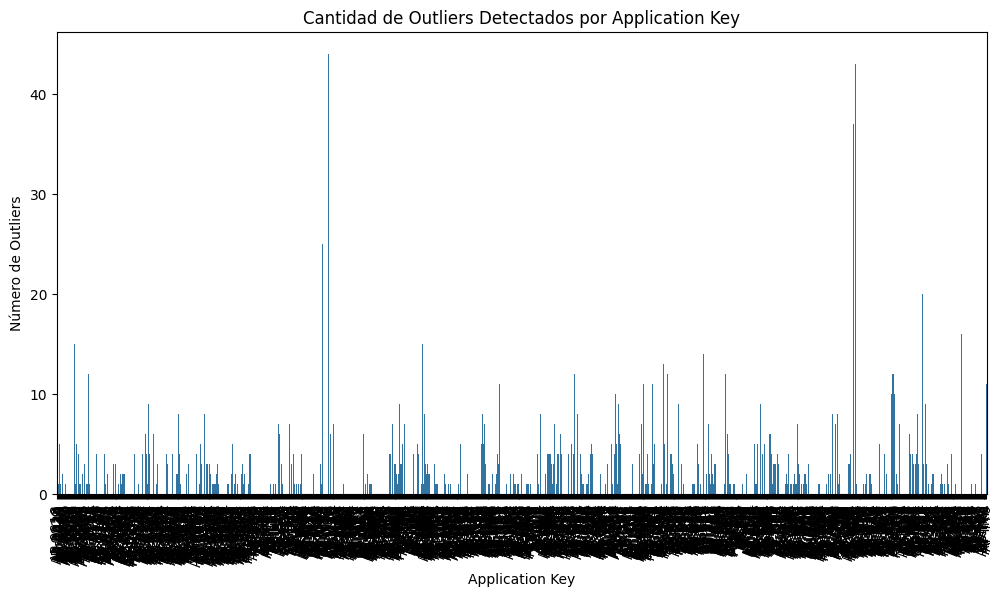

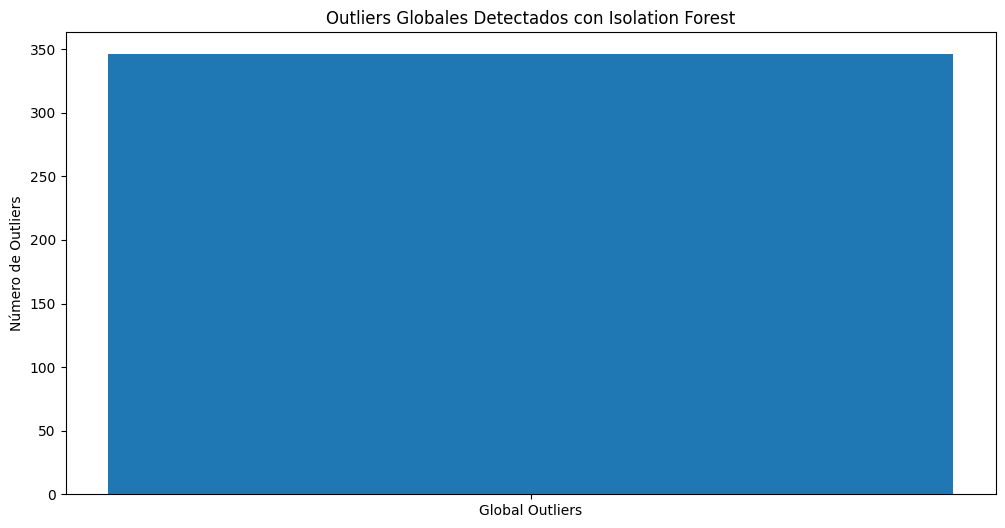

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

input = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_limpio.csv"
output = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_con_tiempos_fuera_de_rango.csv"

df = pd.read_csv(input)

# Evaluar la Distribución de elapsed_time por applicationKey
distribution_results = {}

for app_key, group in df.groupby("applicationKey"):
    # CASO 1: Todos los tiempos son iguales o 0 → No hay outliers
    if group["elapsed_time"].nunique() == 1:
        method = "No Outliers"
    else:
        skewness = group["elapsed_time"].skew()
        method = "Z-score" if abs(skewness) < 1 else "IQR"

    distribution_results[app_key] = method

# Función para Detectar Outliers con el Método Adecuado
def detect_outliers(group):
    app_key = group["applicationKey"].iloc[0]
    method = distribution_results[app_key]

    if method == "No Outliers":
        group["outlier_elapsed_time"] = 0  # No marcar ningún outlier
    elif method == "Z-score":
        group["elapsed_time_z_score"] = zscore(group["elapsed_time"], nan_policy="omit")
        group["outlier_elapsed_time"] = (abs(group["elapsed_time_z_score"]) > 3).astype(int)
    else:  # Método IQR
        Q1 = group["elapsed_time"].quantile(0.25)
        Q3 = group["elapsed_time"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group["outlier_elapsed_time"] = ((group["elapsed_time"] < lower_bound) | (group["elapsed_time"] > upper_bound)).astype(int)

    return group

# Aplicar el Método Adecuado a Cada applicationKey
df = df.groupby("applicationKey", group_keys=False).apply(detect_outliers)

# Detectar Outliers Globales con Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df["general_outlier_elapsed_time"] = iso_forest.fit_predict(df[["elapsed_time"]])
df["general_outlier_elapsed_time"] = (df["general_outlier_elapsed_time"] == -1).astype(int)  # -1 indica outlier

df.to_csv(output, index=False)
print(f"✅ Detección de outliers completada. Archivo guardado en:\n{output}")

# Visualizar la Cantidad de Outliers por applicationKey
plt.figure(figsize=(12, 6))
outlier_counts = df.groupby("applicationKey")["outlier_elapsed_time"].sum()
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Application Key")
plt.ylabel("Número de Outliers")
plt.title("Cantidad de Outliers Detectados por Application Key")
plt.show()

# Visualizar los Outliers Globales con Isolation Forest
plt.figure(figsize=(12, 6))
global_outliers = df["general_outlier_elapsed_time"].sum()
plt.bar(["Global Outliers"], [global_outliers])
plt.ylabel("Número de Outliers")
plt.title("Outliers Globales Detectados con Isolation Forest")
plt.show()

**4. Consolidar**

In [2]:
import pandas as pd

# Cargar el dataset
file_path = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_con_tiempos_fuera_de_rango.csv"
df = pd.read_csv(file_path)

# Agrupar por groupKey y email y calcular las métricas
agg_df = df.groupby(['groupKey', 'email']).agg(
    total_assigned_exams=('applicationKey', 'count'),
    total_exams_finished=('finished', 'sum'),
    total_exams_unfinished=('finished', lambda x: (x == 0).sum()),
    exam_submission_rate=('finished', 'mean'),
    avg_exam_normalized_score=('normalized_score', 'mean'),
    avg_exam_standard_score=('std_score', 'mean'),
    max_exam_normalized_score=('normalized_score', 'max'),
    min_exam_normalized_score=('normalized_score', 'min'),
    exam_score_variability=('normalized_score', 'std'),
    total_perfect_exam_scores=('normalized_score', lambda x: (x == 10).sum()),
    total_questions_answered=('TotalQuestions', 'sum'),
    total_correct_answers=('CorrectAnswers', 'sum'),
    total_incorrect_answers=('IncorrectAnswers', 'sum'),
    accuracy_rate=('CorrectAnswers', lambda x: x.sum() / x.index.size),
    total_time_spent_on_exams=('elapsed_time', 'sum'),
    avg_exam_time=('elapsed_time', 'mean'),
    max_exam_time=('elapsed_time', 'max'),
    min_exam_time=('elapsed_time', 'min'),
    outlier_exam_attempts=('outlier_elapsed_time', 'sum'),
    general_outlier_exam_attempts=('general_outlier_elapsed_time', 'sum'),
    outlier_exam_rate=('outlier_elapsed_time', lambda x: x.sum() / x.index.size)
).reset_index()

# Calcular incidencias manualmente
df['exam_incidents'] = (df['finished'] == 0).astype(int) + df['outlier_elapsed_time'] + df['general_outlier_elapsed_time']
incidents_df = df.groupby(['groupKey', 'email'])['exam_incidents'].agg(
    total_exam_incidents='sum',
    avg_exam_incidents='mean'
).reset_index()

# Fusionar los resultados finales
agg_df = agg_df.merge(incidents_df, on=['groupKey', 'email'], how='left')

# Imputar valores nulos con 0 en las columnas requeridas
agg_df = agg_df.assign(
    avg_exam_standard_score=agg_df['avg_exam_standard_score'].fillna(0),
    exam_score_variability=agg_df['exam_score_variability'].fillna(0)
)

# Guardar el archivo consolidado
output_file = "/content/drive/MyDrive/Doctorado/Experimentos/Datos/DSv4.0/1. Para tratar/examenes/examenes_consolidados.csv"
agg_df.to_csv(output_file, index=False)

# Mostrar el DataFrame en Colab
from IPython.display import display
display(agg_df)


,groupKey,email,total_assigned_exams,total_exams_finished,total_exams_unfinished,exam_submission_rate,avg_exam_normalized_score,avg_exam_standard_score,max_exam_normalized_score,min_exam_normalized_score,...,accuracy_rate,total_time_spent_on_exams,avg_exam_time,max_exam_time,min_exam_time,outlier_exam_attempts,general_outlier_exam_attempts,outlier_exam_rate,total_exam_incidents,avg_exam_incidents
0,GP-230,achucuan@ucol.mx,5,0,5,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,5,1.000000
1,GP-230,agonzalez47@ucol.mx,5,0,5,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,5,1.000000
2,GP-230,amora0@ucol.mx,5,0,5,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,5,1.000000
3,GP-230,arodriguez37@ucol.mx,5,0,5,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,5,1.000000
4,GP-230,avenegas11@ucol.mx,5,0,5,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,5,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,GP-HFO,vgonzalez38@ucol.mx,3,2,1,0.666667,4.1,0.068216,6.8,0.0,...,12.0,83,27.666667,48,0,0,0,0.0,1,0.333333
6377,GP-HFO,vperez8@ucol.mx,1,1,0,1.000000,0.0,-0.159787,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,0,0.000000
6378,GP-HFO,vviera2@ucol.mx,1,0,1,0.000000,0.0,-0.159787,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,1,1.000000
6379,GP-HFO,yestrada5@ucol.mx,1,0,1,0.000000,0.0,-0.159787,0.0,0.0,...,0.0,0,0.000000,0,0,0,0,0.0,1,1.000000
